# Field Goals: An Observational Study ⛰️

* Hypothesis: Long range field goals have a greater change of conversion at altitude than sea-level.
* Hypothesis: Icing a kicker prior to an attempty reduces the likelihood of conversion.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

from matching.cem import CEM, imbalance
from util.evaluation import odds_ratios, binned_residuals, plot_binned_residuals, to_frame
from util.fg_data import clean, get_data

from tqdm import tqdm
import pandas as pd
import numpy as np
import mysql.connector
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime as dt

plt.style.use('seaborn-darkgrid')
sns.set_palette('colorblind')

## Preprocessing

In [2]:
# load and clean the data
cnx = mysql.connector.connect(user='root', password='mOntie20!mysql', host='127.0.0.1', database='nfl')
df = get_data(cnx, 'g.seas<=2019', xp=False, base='raw_6_cat')
df = clean(df, dropna=False)
df = df.drop(['fkicker', 'home_team', 'stadium', 'team', 'XP', 'humid', 'kicks', 'age', 'form'], axis=1)
df['year'] = df['year']-df['year'].min()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18803 entries, 2166 to 871048
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   good           18803 non-null  int64
 1   distance       18803 non-null  int64
 2   year           18803 non-null  int64
 3   seasons        18803 non-null  int64
 4   temperature    18803 non-null  int32
 5   altitude       18803 non-null  int64
 6   wind           18803 non-null  int32
 7   away_game      18803 non-null  int64
 8   postseason     18803 non-null  int64
 9   iced           18803 non-null  int64
 10  turf           18803 non-null  int64
 11  precipitation  18803 non-null  int64
 12  pressure       18803 non-null  int64
dtypes: int32(2), int64(11)
memory usage: 1.9 MB


In [ ]:
binary = ['altitude', 'iced', 'turf', 'postseason', 'away_game', 'precipitation']
continuous = ['distance', 'year', 'seasons', 'temperature', 'wind', 'pressure']

In [6]:
df.head()

,good,distance,year,seasons,temperature,altitude,wind,away_game,postseason,iced,turf,precipitation,pressure
pid,,,,,,,,,,,,,
2166,1,38,0,17,22,0,10,1,0,0,1,0,1
2185,1,27,0,17,22,0,10,1,0,0,1,0,1
4565,1,36,0,17,26,0,13,0,0,1,0,0,5
8564,1,24,0,17,16,0,16,1,0,0,1,1,1
8628,1,40,0,17,16,0,16,1,0,0,1,1,1


## Correlations

In [7]:
from util.metrics import correlations
df_corr = correlations(df, continuous, binary)
df_corr
# print(df_corr[abs(df_corr['corr'])>0.3].sort_values('corr').round(2).to_latex())
# print(df.loc[:,continuous].corr('spearman').round(2).to_latex())

,cov 1,cov 2,corr,p,type
0,altitude,iced,-0.022132,NaN,tetrachoric
1,altitude,turf,-1.000000,NaN,tetrachoric
2,altitude,postseason,0.237681,NaN,tetrachoric
3,altitude,away_game,-0.056016,NaN,tetrachoric
4,altitude,precipitation,-0.441762,NaN,tetrachoric
...,...,...,...,...,...
61,seasons,wind,-0.101532,2.826191e-44,pearsons
62,seasons,pressure,-0.013511,6.392745e-02,pearsons
63,temperature,wind,-0.258234,4.019768e-284,pearsons
64,temperature,pressure,-0.002755,7.056319e-01,pearsons


In [ ]:
# sns.set(font_scale=1)
# ax = sns.pairplot(df.loc[:,continuous].sample(frac=0.5), diag_kind='hist', plot_kws=dict(s=10, edgecolor="b", linewidth=1))

## Finding H

In [ ]:
from matching.cem import get_imbalance_params

rows = []
cont_bins = range(1, 10)

for h, treatment in tqdm(itertools.product(cont_bins,binary), total=len(binary)*len(cont_bins)):
    bins = get_imbalance_params(df.drop([treatment, 'good'], axis=1),
                                'l1', continuous, h)
    l1 = imbalance(df.drop('good', axis=1), treatment, 'l1', bins)
    rows.append({'L1':l1, 'treatment':treatment, 'H':h})

imb = pd.DataFrame.from_records(rows).loc[imb['L1']<1, :]

ax = sns.lineplot(x='H', y='L1', data=imb, hue='treatment', style='treatment', markers=True)
ax.set_title('L1 profile of raw data', size=16)
ax.set_xlabel('H', size=16)
ax.set_ylabel('L1    ', size=16, rotation='horizontal')
ax.tick_params(labelsize=12, size=2)

## Without Matching

#### Imbalance

In [9]:
def pp(val):
    if val<0.01:
        return '***'
    elif val<0.05:
        return '**'
    elif val<0.1:
        return '*'
    return ''

In [12]:
from matching.cem import UnivariateBalance
multi = {}
imb = {}
for t in binary:
    cem = CEM(df, t, 'good', continuous, H=4)
    multi[t] = cem.preimbalance
    ub = UnivariateBalance(df.drop('good', axis=1), t, 'l1', cem.bins).summary
    imb[t] = ub['imbalance'].round(3).astype(str)+ub['P>|z|'].apply(pp) 

df_imb = pd.DataFrame.from_dict(imb, orient='columns')
df_imb = df_imb.append(pd.DataFrame(multi, index=['multivariate']))
# print(df_imb.to_latex())

In [15]:
print(df_imb.to_latex())

\begin{tabular}{lllllll}
\toprule
{} &  altitude &      iced &      turf & postseason & away\_game & precipitation \\
\midrule
altitude      &       NaN &     0.002 &  0.062*** &   0.027*** &    0.005* &      0.025*** \\
away\_game     &    0.036* &     0.012 &      0.01 &      0.013 &       NaN &         0.016 \\
distance      &  0.047*** &  0.088*** &     0.008 &      0.02* &   0.014** &        0.022* \\
iced          &     0.006 &       NaN &     0.001 &    0.028** &     0.005 &         0.003 \\
postseason    &  0.031*** &    0.01** &  0.008*** &        NaN &     0.002 &      0.025*** \\
precipitation &  0.056*** &     0.002 &  0.033*** &   0.046*** &     0.005 &           NaN \\
pressure      &     0.013 &  0.235*** &     0.001 &    0.021** &     0.005 &         0.023 \\
seasons       &  0.053*** &   0.022** &  0.053*** &      0.031 &     0.006 &      0.052*** \\
temperature   &  0.162*** &    0.025* &  0.085*** &   0.268*** &     0.011 &      0.142*** \\
turf          &  0.461*** 

#### Regression

In [370]:
formulas_s = {t:f'good ~ {t}' for t in df.drop('good', axis=1).columns}
formula_0 = {'main effects':'good ~ '+ ' + '.join(df.drop('good', axis=1).columns)}
formula_1 = {'interactions':'good ~ '+ ' + '.join(df.drop('good', axis=1).columns) + f'+ iced*pressure + altitude*distance'}
formula_2 = {'full':'good ~ ' + ' + '.join(df.drop(['good'], axis=1).columns) + f'+ np.log(wind+1) + np.log(seasons) + iced*pressure + altitude*distance + altitude*np.log(distance)'}
formulas = {**formulas_s, **formula_0, **formula_1, **formula_2}

In [372]:
df_unmatched = pd.DataFrame(columns=['coef', 'P>|z|', 'bse', 'model'])
results = {}
for name, formula in formulas.items():
    glm = smf.glm(formula, data=df, family=sm.families.Binomial())
    result = glm.fit(method='bfgs', maxiter=10000)
    results[name] = result
    df_unmatched = pd.concat((df_unmatched, pd.DataFrame({'coef':result.params, 'P>|z|':result.pvalues, 'bse': result.bse, 'model':name})))

df_unmatched.index.rename('covariate', inplace=True)
df_unmatched = df_unmatched.reset_index('covariate')
results = pd.Series(results, name='model')

In [373]:
df_unmatched.head()

,covariate,coef,P>|z|,bse,model
0,Intercept,6.091820,0.000000e+00,0.113231,distance
1,distance,-0.108927,0.000000e+00,0.002568,distance
2,Intercept,1.465018,0.000000e+00,0.037945,year
3,year,0.024866,3.888169e-12,0.003582,year
4,Intercept,1.563687,0.000000e+00,0.036535,seasons


In [374]:
results.head()

distance       <statsmodels.genmod.generalized_linear_model.G...
year           <statsmodels.genmod.generalized_linear_model.G...
seasons        <statsmodels.genmod.generalized_linear_model.G...
temperature    <statsmodels.genmod.generalized_linear_model.G...
altitude       <statsmodels.genmod.generalized_linear_model.G...
Name: model, dtype: object

#### Difference of proportions coefs, OR and p-values

Note each row is a separate regression

In [28]:
def dops(res):
    assert len(res.params) < 3, 'DOPS not available for models with more than one DV (excluding Intercept)'
    predictor = res.model.exog_names[-1]
    exog_0 = pd.DataFrame({predictor: [0]})
    exog_1 = pd.DataFrame({predictor: [1]})
    return res.predict(exog_1) - res.predict(exog_0)

In [ ]:
df_dops = df_unmatched.loc[(df_unmatched['model'].isin(df.columns)) & (df_unmatched['covariate']!='Intercept'), :]
df_dops['OR'] = np.exp(df_dops['coef'])
df_dops.set_index('covariate', inplace=True)
df_dops['DOPS'] = results[df_dops.index].apply(lambda x: dops(x))
df_dops

In [ ]:
# print(df_dops.drop('model', axis=1).round(4)[['DOPS', 'coef', 'OR', 'P>|z|']].to_latex())

#### Odds ratios when setting a p-value

These values for full and interactions will be WRONG if interaction terms are significant at that value

In [380]:
cols = {}
p = 0.1
for name, s in df_unmatched.groupby('model'):
    if name in continuous:
        continue
    ORr = {}
    for t in binary:
        if name in ('main effects', 'interactions', 'full', t):
            OR = odds_ratios(s.set_index('covariate'), t, p=p, plot=False).iloc[0, 0]
            ORr[t] = OR            
    cols[name] = ORr
ors = pd.DataFrame.from_dict(cols, orient='columns').round(3)
ors['univariate'] = ors[binary].transform(max)
ors.drop(binary, axis=1, inplace=True)
ors

,full,interactions,main effects,univariate
altitude,1.000,1.000,1.526,1.000
away_game,1.000,1.000,1.000,1.000
iced,1.000,1.000,0.885,0.695
turf,1.219,1.198,1.198,1.229
postseason,1.000,1.000,1.000,1.000
precipitation,0.774,0.776,0.776,0.734


#### Odds ratios vs the interacting variable

In [379]:
args_0 = ['altitude', 'distance', range(25,65)]
args_1 = ['iced', 'pressure', [0,1,2,3,4,5,6]]
args_all = [args_0, args_1]
frames = []

for args in args_all:
    OR = None
    for name, s in df_unmatched.groupby('model'):
        if name in ('main effects', 'interactions', 'full', args[0]):
            res_ = odds_ratios(s.set_index('covariate'), *args, plot=False, p=1)
            res_['model'] = name if name!=args[0] else 'univariate'
            if OR is None:
                OR = res_
            else:
                OR = pd.concat((OR, res_))
    frames.append(OR)

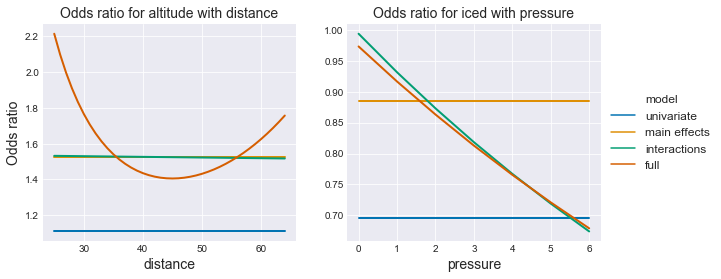

In [381]:
fig, axes = plt.subplots(1,2, sharey=False)
for OR_i, args, ax in zip(frames, args_all, axes):
    ax = sns.lineplot(x=args[1], y='OR', data=OR_i, hue='model', ax=ax, 
                      hue_order=['univariate', 'main effects', 'interactions', 'full'], 
                      linewidth=2)
    ax.set_title(f'Odds ratio for {args[0]} with {args[1]}', size=14)
    ax.set_xlabel(args[1], size=14)
    ax.set_ylabel('Odds ratio', size=14)
    ax.get_legend().remove()

ax.legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=12)
ax.set_ylabel('')
fig.set_size_inches(10, 4)
plt.show()

### Analysis of Residuals

Using 137 bins.
94.9 % of train bins mean residuals within bounds.


Text(0.5, 1.0, 'Binned residuals on pred')

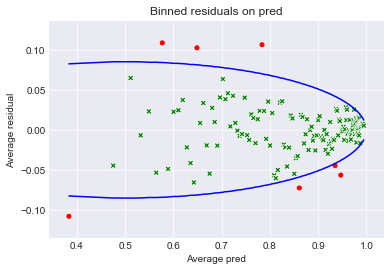

In [384]:
on = 'pred'
resid = binned_residuals(results['full'], df.drop('good', axis=1), df['good'], bins=None, on=on)
print(round(resid['inside'].mean()*100,1), r'% of train bins mean residuals within bounds.')
ax = plot_binned_residuals(resid, on=on)
ax.set_title(f'Binned residuals on {on}')

## With Matching

### Coarsening

In [184]:
def var_plot(data, var, cuts=3, func=pd.cut, bins=None, **kwargs):
    ax = sns.distplot(data[var], kde=False, bins=bins)    
    out, bins = func(data[var], cuts, retbins=True, **kwargs)
    for bin_ in bins:
        plt.axvline(bin_, color='r', linestyle='dashed', linewidth=2)
    return ax, out

IntervalIndex([(-0.019, 3.8], (3.8, 7.6], (7.6, 11.4], (11.4, 15.2], (15.2, 19.0]],
              closed='right',
              dtype='interval[float64]')

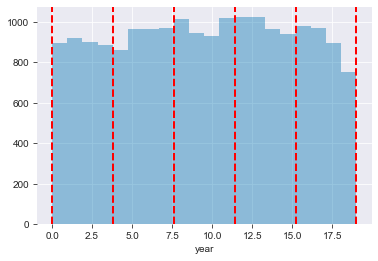

In [430]:
ax, bins = var_plot(df, 'year', cuts=5, bins=df['year'].nunique())
ax.tick_params(size=4)
bins.cat.categories

IntervalIndex([(0, 4], (4, 10], (10, 18], (18, 30]],
              closed='right',
              dtype='interval[int64]')

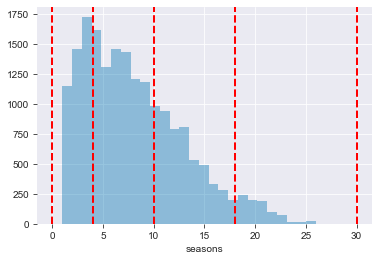

In [195]:
ax, bins = var_plot(df, 'seasons', cuts=[0,4,10,18,30], bins=df['seasons'].nunique(), func=pd.cut)
ax.tick_params(size=4)
bins.cat.categories

IntervalIndex([(-25, -5], (-5, 5], (5, 15], (15, 25], (25, 35], (35, 45]],
              closed='right',
              dtype='interval[int64]')

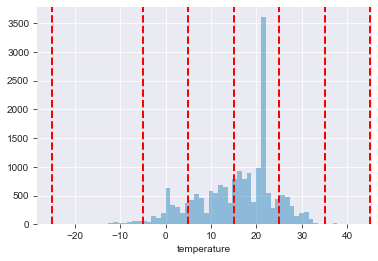

In [199]:
ax, bins = var_plot(df, 'temperature', cuts=[-25,-5,5,15,25,35,45], bins=int(df['temperature'].nunique()), func=pd.cut)
ax.tick_params(size=4)
bins.cat.categories

IntervalIndex([(-0.1, 12.0], (12.0, 25.0], (25.0, 41.0]],
              closed='right',
              dtype='interval[float64]')

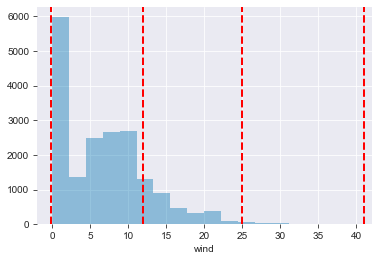

In [200]:
ax, bins = var_plot(df, 'wind', cuts=[-0.1,12,25,41], bins=int(df['wind'].nunique()/2), func=pd.cut)
ax.tick_params(size=4)
bins.cat.categories


IntervalIndex([(-0.006, 2.0], (2.0, 4.0], (4.0, 6.0]],
              closed='right',
              dtype='interval[float64]')

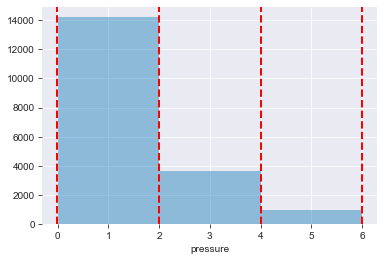

In [201]:
ax, bins = var_plot(df, 'pressure', cuts=3, bins=int(df['pressure'].nunique()/2), func=pd.cut)
ax.tick_params(size=4)
bins.cat.categories

IntervalIndex([(17.942, 25.25], (25.25, 32.5], (32.5, 39.75], (39.75, 47.0], (47.0, 54.25], (54.25, 61.5], (61.5, 68.75], (68.75, 76.0]],
              closed='right',
              dtype='interval[float64]')

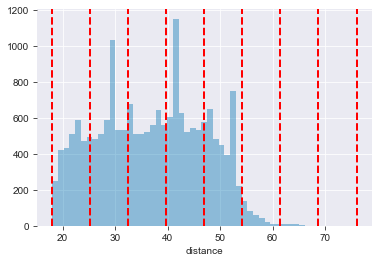

In [235]:
ax, bins = var_plot(df, 'distance', cuts=8, bins=int(df['distance'].nunique()), func=pd.cut)
ax.tick_params(size=4)
bins.cat.categories

In [316]:
coarsening = {
    'distance': {'bins':10, 'cut': 'cut'}, # relax over
    'year': {'bins': 4, 'cut': 'cut'}, # uniform so qcut=cut
    'seasons': {'bins': [0,4,10,18,30], 'cut': 'cut'},
    'temperature': {'bins': [-25,-5,5,15,25,35,45], 'cut': 'cut'},
    'wind': {'bins': [-0.1,12,25,41], 'cut': 'cut'},
    'pressure': {'bins': 3, 'cut': 'cut'},
    'postseason': {'bins': 2, 'cut': 'cut'},
    'iced': {'bins': 2, 'cut': 'cut'},
    'precipitation': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
    'turf': {'bins': 2, 'cut': 'cut'},
    'away_game': {'bins': 2, 'cut': 'cut'},
    'altitude': {'bins': 2, 'cut': 'cut'},
}
coarsening

{'distance': {'bins': 12, 'cut': 'cut'},
 'year': {'bins': 5, 'cut': 'cut'},
 'seasons': {'bins': [0, 4, 10, 18, 30], 'cut': 'cut'},
 'temperature': {'bins': [-25, -5, 5, 15, 25, 35, 45], 'cut': 'cut'},
 'wind': {'bins': [-0.1, 12, 25, 41], 'cut': 'cut'},
 'pressure': {'bins': 3, 'cut': 'cut'},
 'postseason': {'bins': 2, 'cut': 'cut'},
 'iced': {'bins': 2, 'cut': 'cut'},
 'precipitation': {'bins': 2, 'cut': 'cut'},
 'altitude': {'bins': 2, 'cut': 'cut'},
 'turf': {'bins': 2, 'cut': 'cut'},
 'away_game': {'bins': 2, 'cut': 'cut'}}

#### Imbalance

In [317]:
df_imb = None
multi = {}
matched = {}
t_matched = {}
uni = {}
for t in binary:
    cem = CEM(df, t, 'good', continuous, H=4)
    ub = cem.univariate_imbalance(coarsening).summary
    # print(ub)
    uni[t] = ub['imbalance'].round(3).astype(str)+ub['P>|z|'].apply(pp)
    matched_ = cem.match(coarsening)>0
    matched[t] = matched_.sum()
    t_matched[t] = (df.loc[matched_, t] == 1).sum()/(df[t]==1).sum()*100
    multi[t] = cem.imbalance(coarsening)

df_imb = pd.DataFrame.from_dict(uni, orient='columns')
df_imb = df_imb.append(pd.DataFrame(multi, index=['multivariate']))
df_imb = df_imb.append(pd.DataFrame(matched, index=['% matched'])/len(df)*100)
df_imb = df_imb.append(pd.DataFrame(t_matched, index=['% treatment matched']))
# print(df_imb.to_latex())

In [318]:
df_imb

,altitude,iced,turf,postseason,away_game,precipitation
altitude,NaN,0.008***,0.0,0.02***,0.001,0.003
away_game,0.051*,0.007,0.0,0.028,NaN,0.031*
distance,0.021,0.051***,0.013,0.046,0.015**,0.029
iced,0.038***,NaN,0.003,0.039***,0.002,0.029***
postseason,0.018***,0.011***,0.001,NaN,0.0,0.012***
precipitation,0.004,0.024***,0.002,0.052***,0.004,NaN
pressure,0.051*,0.083***,0.005,0.013,0.003,0.019**
seasons,0.02,0.02,0.037***,0.024,0.029***,0.034
temperature,0.115***,0.079***,0.059*,0.208***,0.02,0.122***
turf,0.0,0.039***,NaN,0.078***,0.003,0.034**


### Regressions

In [319]:
weights = {t:CEM(df, t, 'good', continuous, H=4).match(coarsening) for t in binary}
drop = {'altitude': ['turf'], 'turf': ['altitude']}

In [320]:
df_matched = pd.DataFrame(columns=['coef', 'P>|z|', 'bse', 'model', 'treatment'])
results_matched = []
models = ['univariate', 'main effects', 'interactions', 'full']

for t, model in itertools.product(binary, models):
    if model == 'univariate':
        formula = f'good ~ {t}'
    elif model == 'main effects':
        formula = 'good ~ '+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns)
    elif model == 'interactions' and t == 'turf':
        formula = 'good ~'+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns) + ' + iced*pressure'
    elif model == 'interactions':
        formula = 'good ~'+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns) + ' + iced*pressure + altitude*distance'
    elif model == 'full' and t == 'turf':
        formula = 'good ~'+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns) +\
        '+ np.log(wind+1) + np.log(seasons) + iced*pressure'
    elif model == 'full':
        formula = 'good ~'+ ' + '.join(df.drop(['good']+drop.get(t, []), axis=1).columns) +\
        ' + np.log(wind+1) + np.log(seasons) + iced*pressure + altitude*distance + altitude*np.log(distance)'
    # print(t, model)
    # print(formula)
    w = weights[t]
    glm = smf.glm(formula,
                data=df[w > 0],
                family=sm.families.Binomial(),
                var_weights=w[w > 0])
    result = glm.fit(method='bfgs', maxiter=1000)
    results_matched.append({'model': model, 'result':result, 'treatment': t})
    df_matched = pd.concat((df_matched, pd.DataFrame({'coef':result.params, 
                                                      'P>|z|':result.pvalues, 
                                                      'bse': result.bse,
                                                      'model':model, 
                                                      'treatment':t})))

df_matched.index.rename('covariate', inplace=True)
df_matched.reset_index('covariate', inplace=True)
results_matched = pd.DataFrame.from_records(results_matched)

C:\Users\Lewis.Bails\AppData\Local\Continuum\anaconda3\envs\conda_pymc3\lib\site-packages\statsmodels\base\model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Lewis.Bails\AppData\Local\Continuum\anaconda3\envs\conda_pymc3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [321]:
df_matched.head(5)

,covariate,coef,P>|z|,bse,model,treatment
0,Intercept,1.783139,1.360813e-172,0.063669,univariate,altitude
1,altitude,-0.055392,7.045009e-01,0.146055,univariate,altitude
2,Intercept,5.788375,2.170507e-38,0.446769,main effects,altitude
3,distance,-0.119436,4.860218e-48,0.008202,main effects,altitude
4,year,0.043032,1.859539e-04,0.011514,main effects,altitude


In [322]:
results_matched.head(5)

,model,result,treatment
0,univariate,<statsmodels.genmod.generalized_linear_model.G...,altitude
1,main effects,<statsmodels.genmod.generalized_linear_model.G...,altitude
2,interactions,<statsmodels.genmod.generalized_linear_model.G...,altitude
3,full,<statsmodels.genmod.generalized_linear_model.G...,altitude
4,univariate,<statsmodels.genmod.generalized_linear_model.G...,iced


#### Simple

In [323]:
def summarise(row, diff=True):
    out = {}
    out['coef'] = row['result'].params[row['treatment']]
    out['std err'] = row['result'].bse[row['treatment']]
    out['OR'] = np.exp(out['coef'])
    out['P>|z|'] = row['result'].pvalues[row['treatment']]
    out['treatment'] = row['treatment']
    if diff:
        out['DOPS'] = dops(row['result'])[0]
    return pd.Series(out)

In [324]:
def expand_for_treatment(row):
    summary_frame = to_frame(row['result'].summary())
    covs = [i for i in summary_frame.index if row['treatment'] in i]
    sub_summary = summary_frame.loc[covs, ['coef', 'P>|z|', 'std err']]
    sub_summary['OR'] = np.exp(sub_summary['coef'])
    sub_summary['treatment'] = row['treatment']
    sub_summary.set_index('treatment', append=True, inplace=True)
    return sub_summary.reorder_levels([1,0])

In [325]:
results_matched.loc[results_matched['model']=='univariate', :].apply(summarise, axis=1).set_index('treatment') # with DOPS

,coef,std err,OR,P>|z|,DOPS
treatment,,,,,
altitude,-0.055392,0.146055,0.946114,7.045009e-01,-0.006960
iced,-0.246885,0.074650,0.781231,9.422186e-04,-0.033450
turf,0.216033,0.050322,1.241143,1.762610e-05,0.026259
postseason,-0.102215,0.151310,0.902836,4.993385e-01,-0.010162
away_game,-0.059566,0.048157,0.942174,2.161268e-01,-0.007371
precipitation,-0.549451,0.084553,0.577267,8.124031e-11,-0.076700


In [326]:
results_uni = results_matched.loc[results_matched['model']=='univariate', :]
df_uni = pd.concat(results_uni.apply(expand_for_treatment, axis=1).to_list())
df_uni

,,coef,P>|z|,std err,OR
treatment,covariate,,,,
altitude,altitude,-0.0554,0.705,0.146,0.946107
iced,iced,-0.2469,0.001,0.075,0.781219
turf,turf,0.2160,0.000,0.050,1.241102
postseason,postseason,-0.1022,0.499,0.151,0.902849
away_game,away_game,-0.0596,0.216,0.048,0.942141
precipitation,precipitation,-0.5495,0.000,0.085,0.577238


#### Main effects

In [327]:
results_main = results_matched.loc[results_matched['model']=='main effects', :]
df_main = pd.concat(results_main.apply(expand_for_treatment, axis=1).to_list())
df_main

,,coef,P>|z|,std err,OR
treatment,covariate,,,,
altitude,altitude,0.1078,0.503,0.161,1.113825
iced,iced,-0.0963,0.235,0.081,0.908192
turf,turf,0.2011,0.000,0.056,1.222747
postseason,postseason,-0.0717,0.668,0.167,0.930810
away_game,away_game,-0.0259,0.615,0.052,0.974433
precipitation,precipitation,-0.3700,0.000,0.092,0.690734


#### Interactions

In [328]:
results_inters = results_matched.loc[results_matched['model']=='interactions', :]
df_inters = pd.concat(results_inters.apply(expand_for_treatment, axis=1).to_list())
df_inters

0                                  coef  P>|z|  std err        OR
treatment     covariate                                          
altitude      altitude           0.4874  0.603    0.938  1.628078
              altitude:distance -0.0086  0.679    0.021  0.991437
iced          iced               0.0706  0.626    0.145  1.073152
              iced:pressure     -0.1263  0.161    0.090  0.881350
turf          turf               0.1997  0.000    0.056  1.221036
postseason    postseason        -0.0659    NaN      NaN  0.936224
away_game     away_game         -0.0261  0.613    0.052  0.974238
precipitation precipitation     -0.3693  0.000    0.092  0.691218

#### Non-linear transformations

In [329]:
results_full = results_matched.loc[results_matched['model']=='full', :]
df_full = pd.concat(results_full.apply(expand_for_treatment, axis=1).to_list())
df_full

0                                           coef  P>|z|  std err  \
treatment     covariate                                            
altitude      altitude                   11.7619  0.606   22.802   
              altitude:distance           0.0834  0.682    0.204   
              altitude:np.log(distance)  -4.0759  0.627    8.399   
iced          iced                        0.0594  0.682    0.145   
              iced:pressure              -0.1247  0.167    0.090   
turf          turf                        0.2202  0.000    0.060   
postseason    postseason                 -0.0825  0.623    0.168   
away_game     away_game                  -0.0274  0.595    0.051   
precipitation precipitation              -0.3860  0.000    0.093   

0                                                   OR  
treatment     covariate                                 
altitude      altitude                   128270.936850  
              altitude:distance               1.086977  
              altitude:np.log(distance)       0.016977  
iced          iced                            1.061200  
              iced:pressure                   0.882762  
turf          turf                            1.246326  
postseason    postseason                      0.920811  
away_game     away_game                       0.972972  
precipitation precipitation                   0.679771

#### Odds Ratios

In [330]:
formula_summaries = {'univariate':df_uni, 'main effects':df_main, 'interactions':df_inters, 'full':df_full}
args = {'altitude':['distance', range(25,65)], 'iced':['pressure', [0,1,2,3,4,5,6]]}
frames = {}

for treatment, hue in args.items():
    OR_mt = None
    for model_type, d in formula_summaries.items():
        d_t = d.loc[treatment, :]
        res_ = odds_ratios(d_t, treatment, hue[0], hue[1], plot=False, p=1)
        res_['model'] = model_type
        res_['treatment'] = treatment
        if OR_mt is None:
            OR_mt = res_
        else:
            OR_mt = pd.concat((OR_mt, res_))
    frames[treatment] = OR_mt


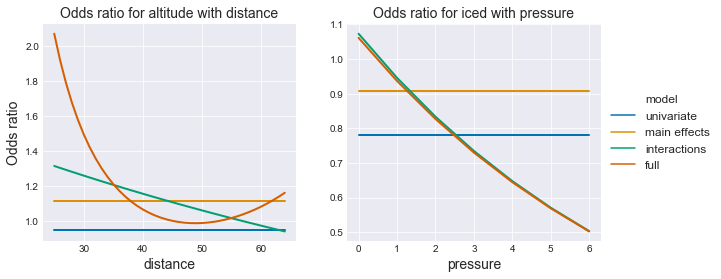

In [331]:
fig, axes = plt.subplots(1,2, sharey=False)
axes = {'altitude':axes[0], 'iced': axes[1]}
for treatment in ('altitude', 'iced'):
    ORs = frames[treatment]
    x = args[treatment][0]
    ax = sns.lineplot(x=x, y='OR', data=ORs, hue='model', ax=axes[treatment], hue_order=['univariate', 'main effects', 'interactions', 'full'], linewidth=2)
    ax.set_title(f'Odds ratio for {treatment} with {x}', size=14)
    ax.set_xlabel(x, size=14)
    ax.set_ylabel('Odds ratio', size=14)
    ax.get_legend().remove()

# axes[0].set_ylim(top=3.5)
# axes[0].set_xlim(25,65)

axes['iced'].legend(loc='center left', bbox_to_anchor=(1,0.5), fontsize=12)
axes['iced'].set_ylabel('')
fig.set_size_inches(10, 4)
plt.show()